In [1]:
#!pip install pyorbital

In [2]:
import datetime
import cv2 as cv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import firebase_admin
from firebase_admin import firestore
from google.cloud import bigquery, storage
from google.cloud.firestore_v1.base_query import FieldFilter
from google.cloud.firestore_v1 import ArrayUnion, Increment
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import tempfile
from pycontrails.datalib import goes
from pycontrails.physics import units

from pyorbital.orbital import A as EARTH_RADIUS
from pyorbital.orbital import get_observer_look

In [3]:
def lonlat2xyz(lon, lat):
    """Convert lon lat to cartesian.
    """
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

def xyz2lonlat(x, y, z, asin=False):
    """Convert cartesian to lon lat.
    """
    lon = np.rad2deg(np.arctan2(y, x))
    if asin:
        lat = np.rad2deg(np.arcsin(z))
    else:
        lat = np.rad2deg(np.arctan2(z, np.sqrt(x ** 2 + y ** 2)))
    return lon, lat
    
def _get_satellite_elevation(sat_lon, sat_lat, sat_alt, lon, lat):
    """Get satellite elevation
    """
    placeholder_date = datetime.datetime(2000, 1, 1)  # ignored for geospatial
    (_, elevation) = get_observer_look(
            sat_lon, sat_lat, sat_alt/1e3,  # m → km (wanted by get_observer_look)
            placeholder_date, lon, lat, 0)
    return elevation

def _get_parallax_shift_xyz(sat_lon, sat_lat, sat_alt, lon, lat, parallax_distance, correct=True):
    """Calculate the parallax shift in cartesian coordinates.

    Returns:
        Parallax shift in cartesian coordinates in meters.
    """
    sat_xyz = np.hstack(lonlat2xyz(sat_lon, sat_lat)) * sat_alt
    cth_xyz = np.stack(lonlat2xyz(lon, lat), axis=-1) * EARTH_RADIUS*1e3  # km → m
    delta_xyz = cth_xyz - sat_xyz
    sat_distance = np.sqrt((delta_xyz*delta_xyz).sum(axis=-1))
    dist_shape = delta_xyz.shape[:-1] + (1,)  # force correct array broadcasting
    if correct:
        return cth_xyz - delta_xyz*(parallax_distance/sat_distance).reshape(dist_shape)
    else:
        return cth_xyz + delta_xyz*(parallax_distance/sat_distance).reshape(dist_shape)

def parallax_correct(lon, lat, height, goes_da, correct=True):
    sat_lon = goes_da.attrs['geospatial_lat_lon_extent']['geospatial_lon_center']
    sat_lat = goes_da.attrs['geospatial_lat_lon_extent']['geospatial_lat_center']
    sat_alt = goes_da.attrs['goes_imager_projection']['perspective_point_height']
    
    elevation = _get_satellite_elevation(sat_lon, sat_lat, sat_alt, lon, lat)
    parallax_distance = height / np.sin(np.deg2rad(elevation))
    shifted_xyz = _get_parallax_shift_xyz(
            sat_lon, sat_lat, sat_alt, lon, lat, parallax_distance, correct)
    return xyz2lonlat(shifted_xyz[..., 0], shifted_xyz[..., 1], shifted_xyz[..., 2])

In [4]:
goes_handler = goes.GOES(goes.GOESRegion.F)
client = bigquery.Client()
storage_client = storage.Client("contrails-observer")
bucket = storage_client.get_bucket("contrails-observer.appspot.com")
photo_id = 'pAviMIP3wBhP15RSaGzO'

Premature end of JPEG file


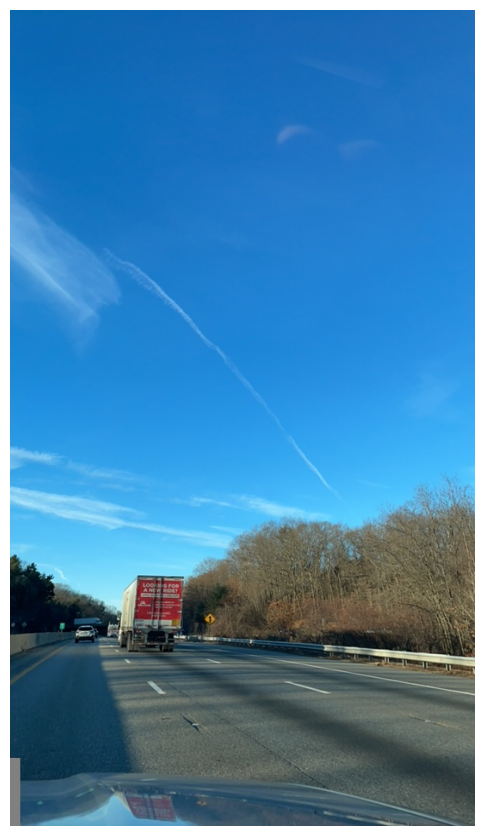

In [5]:
with tempfile.NamedTemporaryFile() as tmp:
    blob = bucket.blob(photo_id)
    blob.download_to_file(tmp)
    fig, ax = plt.subplots(1,figsize=(6,10.6))
    img_color = cv.imread(tmp.name)
    ax.imshow(img_color[...,::-1],aspect='auto')
    ax.set_axis_off()

In [6]:
# Get photo polygons from big query
QUERY = (
    'SELECT timestamp, latitude, longitude, id FROM `contrails-301217.workshop_observerapp.image_metadata`'
    f'WHERE id = "{photo_id}"')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish
ra = list(rows)
assert len(ra) == 1
dt = ra[0].timestamp
latitude = ra[0].latitude
longitude = ra[0].longitude

In [7]:
# Round time up to ten minute interval so it falls on a GOES frame
dt = dt + datetime.timedelta(minutes=10) - datetime.timedelta(minutes=dt.minute % 10, seconds=dt.second,microseconds=dt.microsecond)
tstr = dt.strftime('%Y-%m-%d %H:%M:00')

In [8]:
# Get GOES image and transform info
da = goes_handler.get(tstr)
rgb, src_crs, src_extent = goes.extract_goes_visualization(da, color_scheme="ash")

In [9]:
# Get photo polygons from big query
QUERY = (
    'SELECT geometry, id, level FROM `contrails-301217.workshop_observerapp.image_field_of_view`'
    f'WHERE id = "{photo_id}" '
    'LIMIT 100')
query_job = client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

polygons = {}
for row in rows:
    polygons[row.level] = row.geometry

coord_dict = {}
for lvl in polygons.keys():
    coords_str = [p.split(' ') for p in polygons[lvl][9:-2].split(', ')]
    coords = [[float(lon), float(lat)] for (lon, lat) in coords_str]
    coord_dict[lvl] = coords

In [10]:
corrected_dict = {}
for lvl in coord_dict.keys():
    height = units.ft_to_m(lvl*100)
    corrected = []
    for lon, lat in coord_dict[lvl]:
        corrected.append(parallax_correct(lon, lat, height, da, False))
    corrected_dict[lvl] = corrected

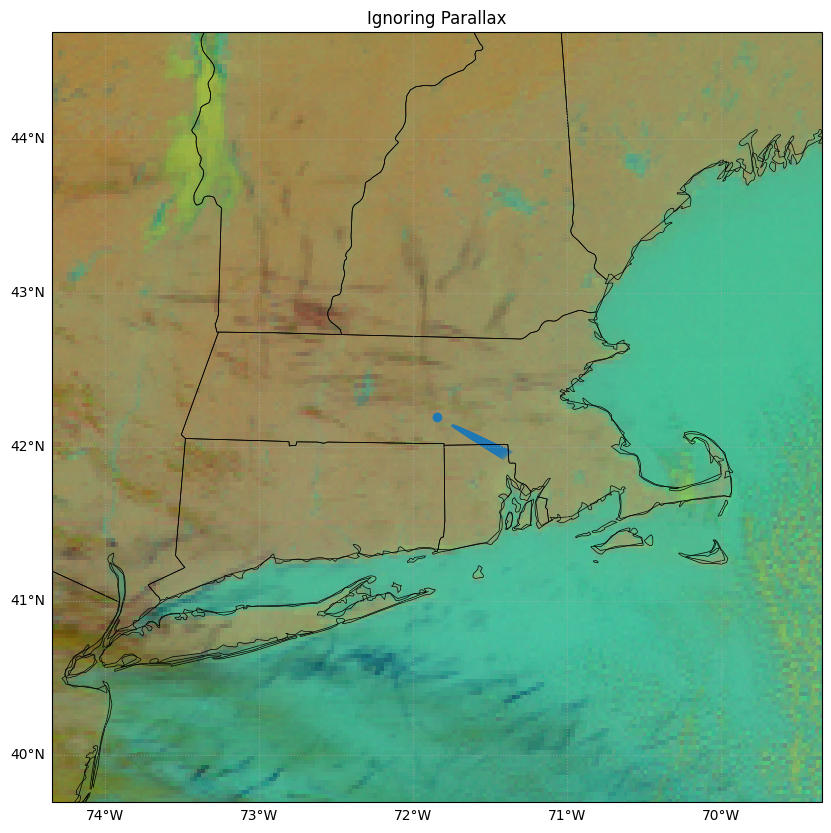

In [20]:
# Uncorrected:
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
for lvl in coord_dict.keys():
    ax.add_patch(mpatches.Polygon(xy=coord_dict[lvl], alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.set_title("Ignoring Parallax")

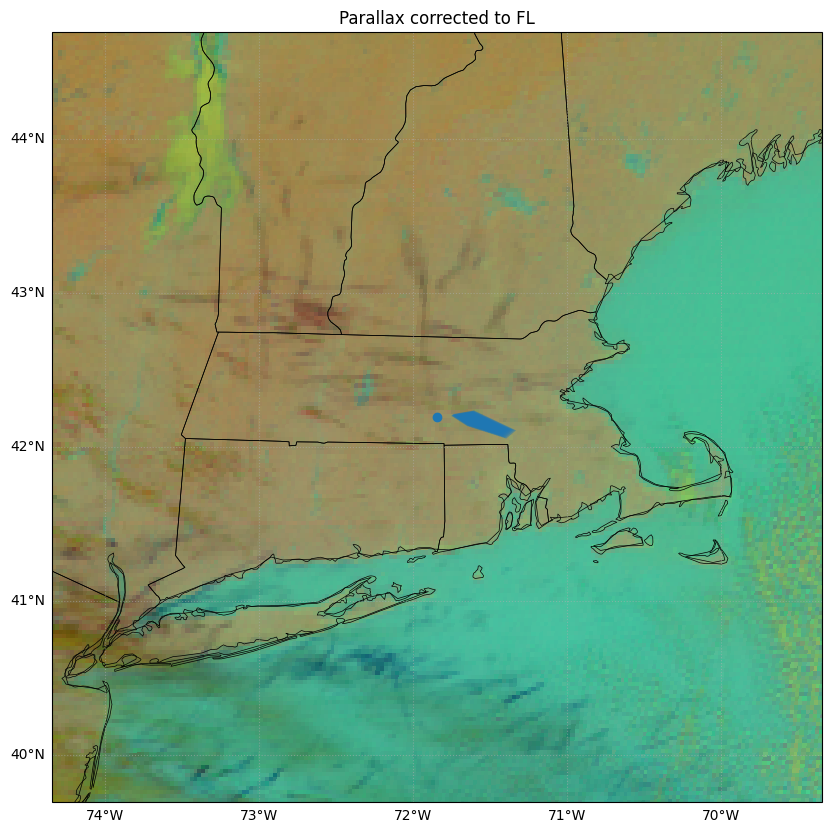

In [21]:
# Corrected:
dst_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=dst_crs, extent=(longitude-2.5, longitude+2.5, latitude-2.5, latitude+2.5))

ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)

ax.imshow(rgb, extent=src_extent, transform=src_crs, origin="upper", interpolation="none")
ax.scatter(longitude, latitude)
for lvl in corrected_dict.keys():
    ax.add_patch(mpatches.Polygon(xy=corrected_dict[lvl], alpha=0.5, transform=dst_crs))
# Set the x and y ticks to use latitude and longitude labels
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle=":")
gl.top_labels = False
gl.right_labels = False

_ = ax.set_title("Parallax corrected to FL")